In [6]:
import numpy as np
from numpy.linalg import svd, norm, qr

def sample_nystrom_candidates(A, X, k, tol, eps, N_samples=1000):
    """
    Sample up to N_samples rank-k matrices hatA satisfying
      ||hatA X - A X||_2 <= tol,
      ||U_hat^* V_hat - Q||_2 <= eps
    where Q is the best orthogonal approx to U_hat^* V_hat.
    
    Returns a list of all the hatA's that passed.
    """
    n, _ = A.shape
    # SVD of A
    U_A, S_A, Vh_A = svd(A, full_matrices=False)
    # truncate to rank k
    U0 = U_A[:, :k]
    S0 = S_A[:k]
    V0 = Vh_A.conj().T[:, :k]
    
    good_As = []
    for _ in range(N_samples):
        # --- 1) build a random low-rank hatA via its SVD factors ---
        # sample random orthonormal U_hat, V_hat near U0,V0:
        # (you could also add noise scaled by tol or eps here if desired)
        Q1, _ = qr(np.random.randn(n, k))      # random unitary basis
        Q2, _ = qr(np.random.randn(n, k))
        # we reuse A's singular values, but you could also perturb them
        Sigma_hat = np.diag(S0)
        
        U_hat = Q1
        V_hat = Q2
        
        hatA = U_hat @ Sigma_hat @ V_hat.conj().T
        
        # --- 2) test the two constraints ---
        # 2a: data‐consistency error
        err_data = norm(hatA @ X - A @ X, 2)
        if err_data > tol:
            continue
        
        # 2b: distance to the nearest orthogonal Q
        M = U_hat.conj().T @ V_hat
        s_min = svd(M, compute_uv=False)[-1]
        err_sym  = 1 - s_min
        if err_sym > eps:
            continue
        
        # passed both tests!
        good_As.append(hatA)
    
    return good_As


# --- example of usage ---
n, r, k = 100, 10, 5
# build A and X as in your setup:
Q, _ = qr(np.random.randn(n, r))
exp_vals = [1e-7,1e-7,1e-7,1e-2,1e-2,1e-2,1e-1,1,1e1,1e2][::-1]
A = Q @ np.diag(exp_vals) @ Q.T
X = np.random.randn(n, r)

tol = 1e-3
eps = 1e-2
candidates = sample_nystrom_candidates(A, X, k, tol, eps, N_samples=500)
print(f"Found {len(candidates)} matrices meeting the criteria.")

def sample_candidates_local(A, X, k, tol, eps, N_samples=1000, angle=0.1):
    U_A, S_A, Vh_A = np.linalg.svd(A, full_matrices=False)
    U0, V0 = U_A[:,:k], Vh_A.conj().T[:,:k]
    Sigma0 = np.diag(S_A[:k])
    good = []

    for _ in range(N_samples):
        # small random skew on the k×k subspace
        R1 = qr(np.eye(k) + angle*np.random.randn(k,k))[0]
        R2 = qr(np.eye(k) + angle*np.random.randn(k,k))[0]

        U_hat = U0 @ R1     # stay near U0
        V_hat = V0 @ R2     # stay near V0

        # reconstruct
        hatA = U_hat @ Sigma0 @ V_hat.conj().T

        # tests as before
        if np.linalg.norm(hatA@X - A@X, 2) > tol: 
            continue
        s_min = np.linalg.svd(U_hat.conj().T@V_hat, compute_uv=False)[-1]
        if 1 - s_min > eps:
            continue

        good.append(hatA)

    return good

candidates = sample_candidates_local(A, X, k, tol, eps, N_samples=5000000, angle=0.05)
print("Local sampling found:", len(candidates))


Found 0 matrices meeting the criteria.
Local sampling found: 0


<>:162: SyntaxWarning: invalid escape sequence '\|'
<>:162: SyntaxWarning: invalid escape sequence '\|'
C:\Users\aleks\AppData\Local\Temp\ipykernel_43848\3883021635.py:162: SyntaxWarning: invalid escape sequence '\|'
  """


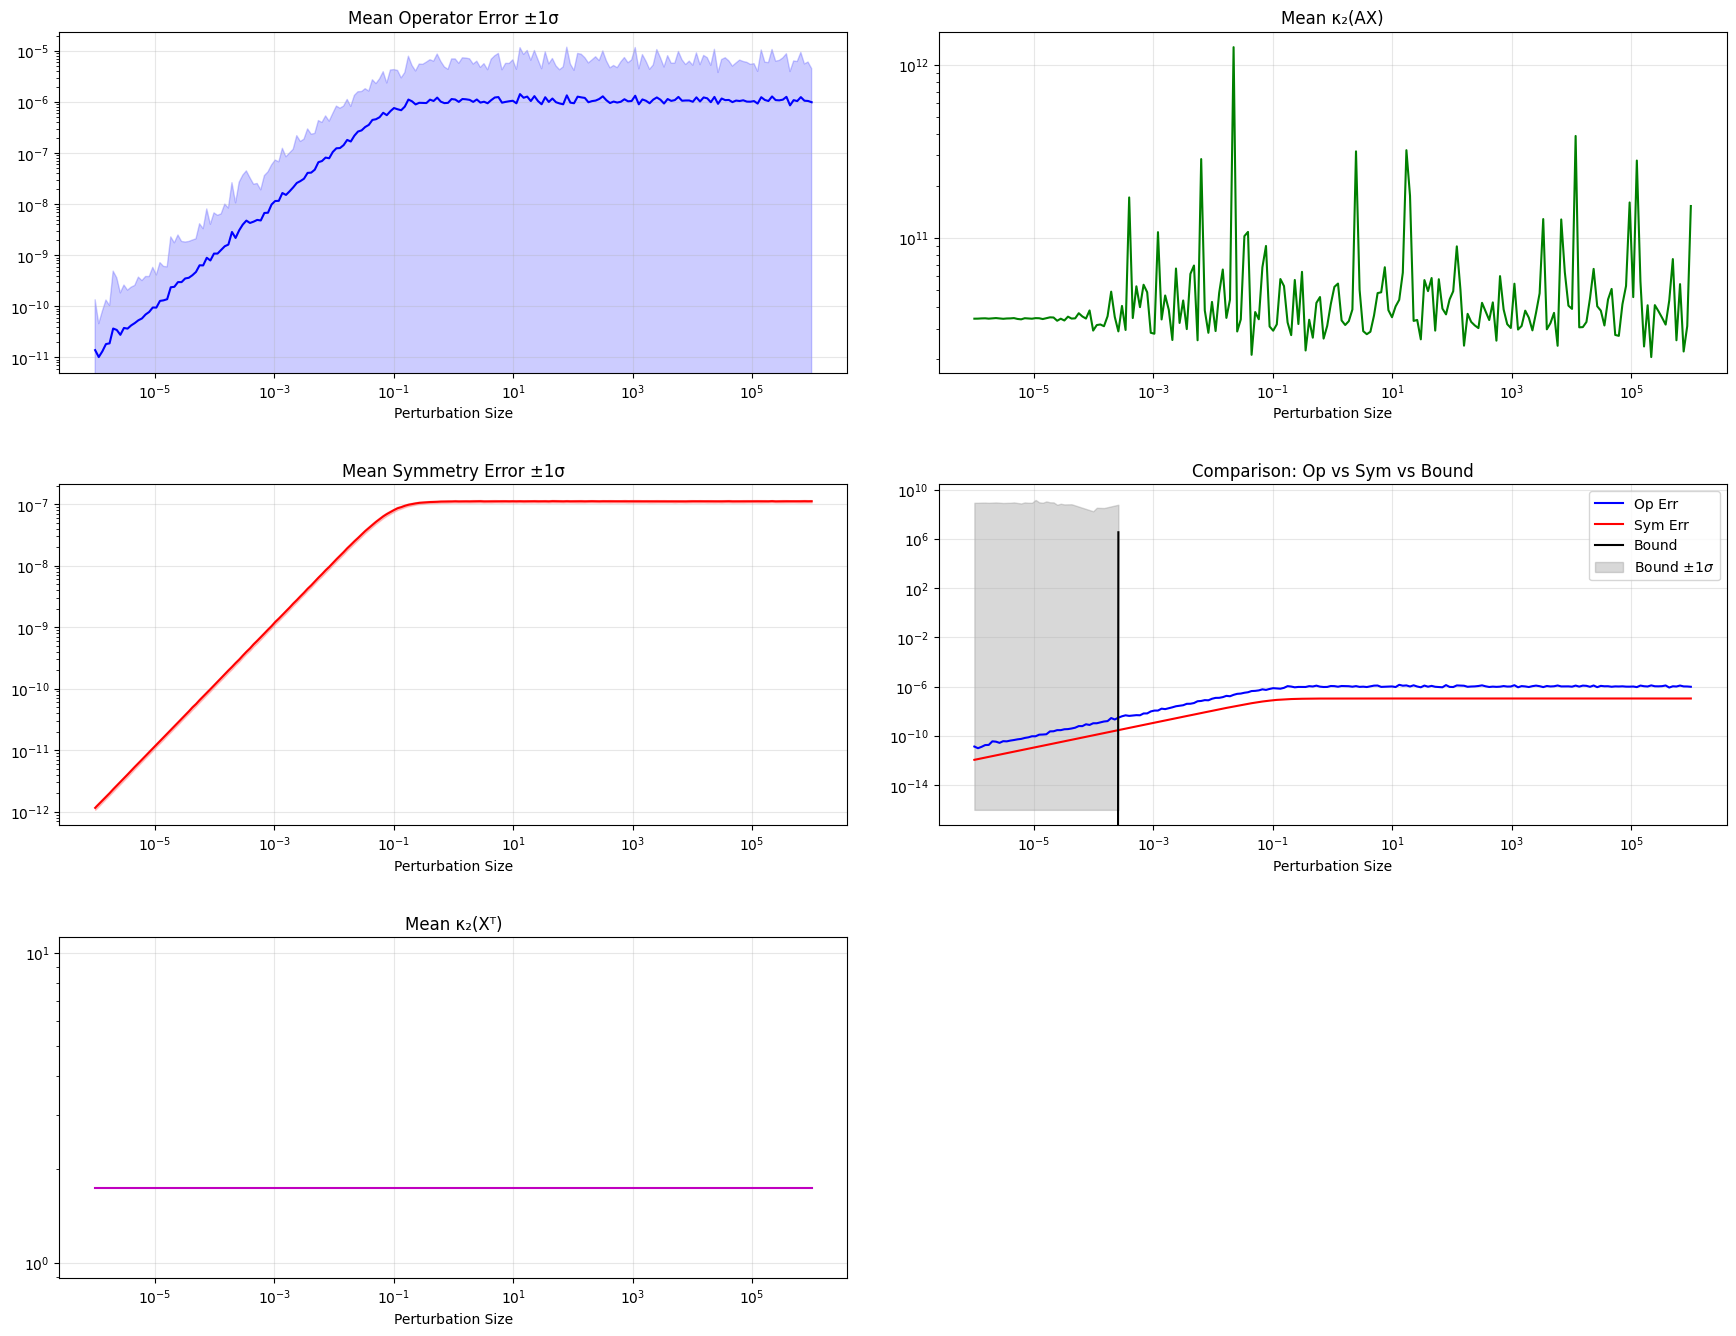

"\n# Plot\nplt.figure(figsize=(8,6))\nplt.loglog(perturbation_size, mean_bound, 'k-')\nplt.fill_between(perturbation_size,\n                 mean_bound - std_bound,\n                 mean_bound + std_bound,\n                 color='gray', alpha=0.3)\nplt.xlabel('Perturbation Size')\nplt.ylabel(r'Bound $4\\|AX\\|\x0crac{c^2\\gamma}{1 - c\\gamma}$')\nplt.title('Theorem 4 Bound vs Perturbation Size')\nplt.grid(True, alpha=0.3)\nplt.tight_layout()\nplt.show()"

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import qr, inv, norm, cond

# -------------------------------------------------
# 1) Problem setup (same as before)
# -------------------------------------------------
n, r       = 100, 10
exp_values = [1e-7,1e-7,1e-7,1e-2,1e-2,1e-2,1e-1,1,1e1,1e2]
exp_values_reversed = exp_values[::-1]

Q, _    = qr(np.random.randn(n, r))
A_base = Q @ np.diag(exp_values_reversed) @ Q.T

small_sv_indices = [-3, -2, -1]
perturbation_size = np.logspace(-6, 6, 200)

# -------------------------------------------------
# 2) Storage for metrics across samples & perturbs
# -------------------------------------------------
sample_size = 500

# shape = (sample_size, n_perturbations)
new_error_all            = np.zeros((sample_size, len(perturbation_size)))
sym_error_all            = np.zeros_like(new_error_all)
cond_AX_all              = np.zeros_like(new_error_all)
cond_XT_all              = np.zeros_like(new_error_all)
bound_all = np.zeros((sample_size, len(perturbation_size)))
c_all              = np.zeros_like(new_error_all)
gamma_all              = np.zeros_like(new_error_all)

# -------------------------------------------------
# 3) Outer loop: for each random X
# -------------------------------------------------
for s in range(sample_size):
    # draw a fresh X for this sample
    X = np.random.randn(n, r)

    # now do your perturbation sweep
    for i, pert_size in enumerate(perturbation_size):
        # targeted perturbation on the smallest singular‐vector slots
        Q_pert = Q.copy()
        for j in small_sv_indices:
            Q_pert[:, j] += pert_size * np.random.randn(n)
        Q_pert, _ = qr(Q_pert)

        # build the perturbed A
        A = Q @ np.diag(exp_values_reversed) @ Q_pert.T
        eps = A - A.T

        e = norm(eps, 2)

        c = (svd(X.T @ Q_pert, compute_uv = False)[0]) / (svd(X.T @ Q_pert, compute_uv = False)[-1])**2

        c_all[s,i] = c

        gamma = np.sqrt(8 * e)

        gamma_all[s,i] = gamma

        # metrics
        cond_XT_all[s,i]   = cond(X.T)
        AX                 = A @ X
        norm_AX = norm(AX, 2)
        cond_AX_all[s,i]   = cond(AX)

        # Nystrom operator‐difference error
        op_diff = AX @ inv(X.T @ AX) @ (X.T @ eps @ X) @ np.linalg.pinv(X)
        new_error_all[s,i] = norm(op_diff, 2)

        # symmetry‐error
        sym_error_all[s,i] = norm(eps, 2)

        bound_all[s, i] = 4 * norm_AX * (c**2 * gamma) / (1 - c * gamma)

# -------------------------------------------------
# 4) Aggregate across the sample dimension
# -------------------------------------------------
mean_op_err  = new_error_all.mean(axis=0)
std_op_err   = new_error_all.std(axis=0)
mean_sym_err = sym_error_all.mean(axis=0)
std_sym_err  = sym_error_all.std(axis=0)

mean_cond_AX = cond_AX_all.mean(axis=0)
mean_cond_XT = cond_XT_all.mean(axis=0)

mean_bound = bound_all.mean(axis=0)
std_bound  = bound_all.std(axis=0)

# -------------------------------------------------
# 5) Plotting: mean curves with ±1 σ bands
# -------------------------------------------------
fig, axes = plt.subplots(3, 2, figsize=(18,14))
ax1, ax2, ax3, ax4, ax5 = axes.flatten()[:5]
axes.flatten()[-1].set_visible(False)

# Operator‐difference error
ax1.loglog(perturbation_size, mean_op_err, 'b-')
ax1.fill_between(perturbation_size,
                 mean_op_err-std_op_err,
                 mean_op_err+std_op_err,
                 color='blue', alpha=0.2)
ax1.set_title('Mean Operator Error ±1σ')

# Conditioning of AX
ax2.loglog(perturbation_size, mean_cond_AX, 'g-')
ax2.set_title('Mean κ₂(AX)')

# Symmetry error
ax3.loglog(perturbation_size, mean_sym_err, 'r-')
ax3.fill_between(perturbation_size,
                 mean_sym_err-std_sym_err,
                 mean_sym_err+std_sym_err,
                 color='red', alpha=0.2)
ax3.set_title('Mean Symmetry Error ±1σ')

lower = mean_bound - std_bound
upper = mean_bound + std_bound

# clip the lower band to a tiny positive value 
# so we never ask fill_between(y1<0, y2>0):
lower_clipped = np.maximum(lower, 1e-16)

# Recompute a mask of where the mean denominator is positive:
mean_denominator = 1 - (c_all.mean(axis=0) * gamma_all.mean(axis=0))
valid = mean_denominator > 1e-16     # only plot where well‐defined

# Now on ax4, instead of plotting all 200 points:
ax4.loglog(perturbation_size, mean_op_err,   'b-', label='Op Err')
ax4.loglog(perturbation_size, mean_sym_err,  'r-', label='Sym Err')

# plot the bound *only* on the valid subset
ax4.loglog(perturbation_size[valid],
           mean_bound[valid],
           'k-',
           label='Bound')

# similarly clip the σ‐band to those same valid points:
lower = mean_bound[valid] - std_bound[valid]
upper = mean_bound[valid] + std_bound[valid]
lower = np.maximum(lower, 1e-16)

ax4.fill_between(perturbation_size[valid],
                 lower, upper,
                 color='gray', alpha=0.3,
                 label=r'Bound $\pm1\sigma$')

ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_title('Comparison: Op vs Sym vs Bound')
ax4.legend()
# Conditioning of Xᵀ
ax5.loglog(perturbation_size, mean_cond_XT, 'm-')
ax5.set_title('Mean κ₂(Xᵀ)')

for ax in (ax1,ax2,ax3,ax4,ax5):
    ax.set_xlabel('Perturbation Size')
    ax.grid(True, alpha=0.3)

plt.tight_layout(pad=3)
plt.show()
"""
# Plot
plt.figure(figsize=(8,6))
plt.loglog(perturbation_size, mean_bound, 'k-')
plt.fill_between(perturbation_size,
                 mean_bound - std_bound,
                 mean_bound + std_bound,
                 color='gray', alpha=0.3)
plt.xlabel('Perturbation Size')
plt.ylabel(r'Bound $4\|AX\|\frac{c^2\gamma}{1 - c\gamma}$')
plt.title('Theorem 4 Bound vs Perturbation Size')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()"""
